# Machine Learning in Neuroimaging
---------------
Why stop at applying ML algorithms to behavioral data when we can apply them to functional neuroimaging! This particular set of methods has exploded in psychology in the last 5-10 years. Let's start by defining some key terms that we'll use in this walkthrough.

### Glossary
--------
* **fMRI** - Functional magnetic resonance imaging. Used to measure changes in blood flow to neural regions during a functional task
* **Voxel** - A three-dimensional spatial representation of a neural region
* **Mask** - The subset of voxels that you want to analyze (helps to reduce noise). Think of it like a stencil
* **NifTI** - File format created by the Neuroimaging Informatics Technology Initative, used to represent high-dimensional data obtained from fMRI scans
* **Classification** - ML algorithm that predicts target's class/group membership

For a good primer on fMRI, see [this article](https://blogs.scientificamerican.com/observations/whats-a-voxel-and-what-can-it-tell-us-a-primer-on-fmri/)

------------


Consider **nilearn** an extension of SK-learn, which we just discussed. In fact, both libraries were developed by the same team! Nilearn is optimized for multi-dimensional data, which makes it an obvious choice for fMRI analysis. We won't go too under the hood with the *nilearn nitty gritty*, but let's take a look at some features that nilearn is especially adept at.
<br> <br>
The dataset I've chosen to work with ([Haxby et al., 2001](https://science.sciencemag.org/content/293/5539/2425)) is a block-design study on **face** vs. **object** representation in the ventral temporal cortex. It consists of 6 participants and 12 total runs across 9 conditions (e.g., bottle, chair, face, cat, etc.).
<br> <br>

-------------

In [1]:
from nilearn import datasets
haxby_data = datasets.fetch_haxby()
target = haxby_data.func[0]

print("Functional images located at: {}".format(target))

Functional images located at: /Users/IanFerguson 1/nilearn_data/haxby2001/subj2/bold.nii.gz


Here we see the local file path for the fMRI images from Haxby et al., 2001. The .nii.gz format indicates that this data is in NifTI format, and is compressed (similar to "zipping" or compressing a directory).

In [2]:
from nilearn import plotting
from nilearn.image import mean_img

plotting.view_img(mean_img(target), threshold=3)

In [3]:
from nilearn import input_data
mask = haxby_data.mask_vt[0]

mask_function = input_data.NiftiMasker(mask_img=mask, standardize=True)
fmri_masked = mask_function.fit_transform(target)

print(fmri_masked)

[[ 7.6757914e-01  2.3108709e+00 -2.0519446e-01 ... -1.0261141e+00
   8.7993503e-02  2.0720530e+00]
 [ 5.5640829e-01  1.6833442e+00 -2.4644940e-01 ... -7.0238096e-01
  -3.4570050e-01  2.0341012e+00]
 [ 7.6757914e-01  1.9186667e+00  1.0802227e-03 ... -9.9374086e-01
  -2.7630946e-01  2.1479564e+00]
 ...
 [-4.2905572e-01 -1.6896113e+00 -7.4150860e-01 ... -1.5440873e+00
   1.8054218e+00 -1.6709729e-01]
 [-1.4749458e-01 -1.8072726e+00 -2.4644940e-01 ... -1.7707006e+00
   1.5452055e+00  7.8169519e-01]
 [-2.1788488e-01 -1.4542887e+00  1.0802227e-03 ... -1.6412073e+00
   1.2676412e+00  8.9555031e-01]]


In [4]:
fmri_masked.shape

(1452, 464)

Interpreting this, we'll be working with **464 voxels of interest** in the ventral temporal cortex.

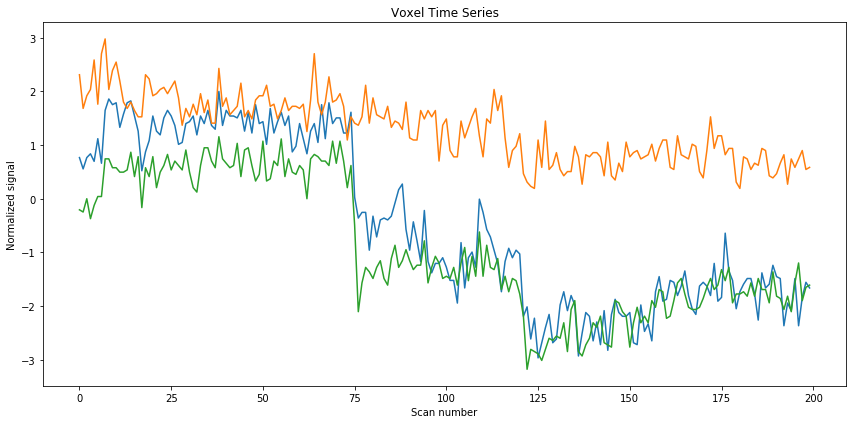

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(fmri_masked[:200, :3])
plt.title('Voxel Time Series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [6]:
import pandas as pd
import numpy as np

behave = pd.read_csv(haxby_data.session_target[0], delimiter=" ")
conditions = behave["labels"]

list(behave["labels"].unique())

['rest',
 'scissors',
 'face',
 'cat',
 'shoe',
 'house',
 'scrambledpix',
 'bottle',
 'chair']

In [7]:
# Limit to FACE vs. CAT discrimination
condition_mask = conditions.isin(['face', 'cat'])

fmri_masked = fmri_masked[condition_mask]
conditions = conditions[condition_mask]

fmri_masked.shape

(216, 464)

Nice! We'll keep the **464 voxels of interest** but only need to analyze 216 volumes (these are the runs with cat or face stimuli presented to participants).

## Decoding with SVM Classifier
------------------
To decode these fMRI runs, we'll use a **Support Vector Machine (SVM) Classifier** - an SVM algorithm attempts to maximally separate Group A from Group B. In this example, we're attempt to separate voxels active in "face" processing from voxels active in "cat" processing.

<br> <br>

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/300px-SVM_margin.png)

<br> <br>
We're going to call two important functions from our SVC:
* **Fit** - 'Learns' the parameters of the model from the data <br>
* **Predict** - Estimates which category the target belongs to

<br> <br>
Notably, we *cannot* predict on the same data that we used to fit the SVC parameters. That would give us a great result in a vacuum, but said results would likely not translate to other data.

---------------

In [8]:
# Import Support Vector Classifier
from sklearn.svm import SVC

# Instantiate + fit SVC with masked fMRI data
svc = SVC(kernel="linear")
svc.fit(fmri_masked, conditions)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [9]:
# Use fitted SVC to predict category membership
predictions = svc.predict(fmri_masked)
print(predictions)

len(predictions)

['face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'face' 'face' 'face' 'face' 'face'
 'face' 'face' 'face' 'face' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat' 'cat'
 'cat' 'cat' 'face' 'face' 'face' 'face' 'face' 'face' 'face' '

216

Looks good! But does it mean anything?
<br> <br>
*Not really*. To obtain more meaningful results, we need to find a way to split our data into training and testing components.

## Cross-Validation
--------------
SK-Learn has a built in K-Fold cross-validation function. We'll split our masked data into five testing segments (i.e., K = 5) ... this will give us a more accurate estimate of the SVC's performance on this data.

In [10]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5)
m=0
scores = []

for train, test in cv.split(X= fmri_masked):
    conditions_masked = conditions.values[train]
    svc.fit(fmri_masked[train], conditions_masked)
    prediction = svc.predict(fmri_masked[test])
    
    m += 1
    
    score = round((prediction==conditions.values[test]).sum() / float(len(conditions.values[test])), 5)
    scores.append(score)
    print("Fold #{}:\t\t{}".format(str(m), str(score)))

Fold #1:		0.97727
Fold #2:		0.76744
Fold #3:		0.7907
Fold #4:		0.53488
Fold #5:		0.74419


In [11]:
np.mean(scores)

0.762896

## Coefficients to NIFTI
------------------
We end up with one coefficient value per voxel. These are **discriminating Beta weights** - in other words, when *Beta* is positive for a voxel it suggests that activation of that voxel is highly correlated with group membership determination.
<br> <br>
Thanks to Stanford's very own Russell Poldrack for [this excellent article](https://watermark.silverchair.com/nsm006.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAApowggKWBgkqhkiG9w0BBwagggKHMIICgwIBADCCAnwGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMvqtdetEkPWvDMIeFAgEQgIICTZnhu1Ss-XAhVgWkphHfspOAkRqGvStuOvnqI7XxYg8IaHmSNNq8T0sR9g_Bi5c3qN4mlmBZYlbolL7MdqkHkdTdT-ol8w3dxqTbqM_zICtyvrfKsjOZ7irSF_gwf6eSR1tGuXTNeo3GOJr9dNQ-JYDZy98S6oP2kPLHrLnIs8pL0kiDC0xC4SmU6CSmASyK3P6gYzjah8z_t14UW2SOtFiUwqndZAVKdc__SalpC68leYisOURS3x5wOVlT0CJ9dDPuMW5MawIOjCjfiCkItvhsYL4fuJCgCmsqjOH3S8K7RxSUDekkaNxFb9SYzHbuXtwE8QlVW8e7QX0OafwKvkKBh4VRzcfQO3Hh4sOZW7YHNJ9RCxjABQBh1CUGWPxnm87LJVzfn152xl2qU1y3pFm5iYCnTPzp6bhImHU_IqJHq5K5ohriWgMC1Ip-tVt2OdjI0Zi1rg4SohRsGXy7oBCxbMgJY5XF9Kgn5NYJ9S6HwdCHiKf5buEF_m4sW2plWGTmbVY9l-a2mQ59EhOzFYIE2dXAA8-av8Pz8cE86YJ3M_jQLYTNT1Gam52xlqqDMZXMPXFrlQ-hMeFKhAOG7Qqg5txuJDDuJ5LmR2T4oq5NBYCCqmi_ICGmbsOdwJGjX4MSiSdN9-19QOL3RlkXzqCZV86d98B7NW7kGDZYHaO9AKqIPUAWevrwly9_-i3QAi8cmWQ-1ZqzD4CpLhjylyWc5vgPTxKR5syt3e1IXdovvEhXtAXu-9lM_UzUFT6p-wYzoNcga3P9Ij-9Trg) on Region of Interest analysis in fMRI! 

In [12]:
coef_ = svc.coef_

coef_[0][:5]

array([-0.04105914, -0.00083891, -0.02349921, -0.03474315,  0.03441007])

In [13]:
print(len(coef_[0]))

464


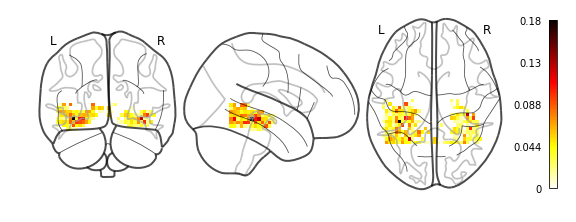

In [14]:
coef_image = mask_function.inverse_transform(coef_)

from nilearn.plotting import plot_glass_brain, show

# Plot coefficients from SVC
plot_glass_brain(coef_image, colorbar=True, plot_abs=True)
show()

## Documentation
------------
* [Sci-Kit Learn Documentation](https://scikit-learn.org/stable/)
* [Nilearn Documentation](https://nilearn.github.io/user_guide.html)
* [PyMVPA Documentation](http://www.pymvpa.org/docoverview.html)

<br>

**Up Next**: [Additional Resources](http://localhost:8888/notebooks/Documents/ACADEMIA/04_Stanford/02_Projects/03_Professional-Dev/00_Python-in-Psych/00/Additional%20Resources.ipynb)